In [1]:
import pickle
import operator

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import chain
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook, tqdm
from sklearn.metrics.pairwise import cosine_similarity

from torch.utils import data
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from torchvision import transforms

# Avoid pil error
pil_image.MAX_IMAGE_PIXELS = None

# For reproducibility purpose
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
train_df_path = '../input/whale-categorization-playground/train.csv'
test_df_path = '../input/whale-categorization-playground/sample_submission.csv'
TRAIN = '../input/whale-categorization-playground/train/train/'
TEST = '../input/whale-categorization-playground/test/test/'

In [3]:
rotate_path = '../input/humpback-whale-identification-model-files/rotate.txt'
exclude_path = '../input/humpback-whale-identification-model-files/exclude.txt'
bboxes_path = '../input/humpback-whale-identification-model-files/bounding-box.pickle'

In [4]:
train_df = pd.read_csv(train_df_path, header=0)
test_df = pd.read_csv(test_df_path)

In [5]:
def expand_path(p):
    '''Takes image name and returns full path'''
    if isfile(TRAIN + p):
        return TRAIN + p
    if isfile(TEST + p):
        return TEST + p
    return p


def show_whale(imgs, per_row=2):
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
    
    for ax in axes.flatten(): 
        ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())): 
        ax.imshow(img.convert('RGB'))


In [6]:
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

In [7]:
# Load array of images to rotate
# https://www.kaggle.com/martinpiotte/humpback-whale-identification-model-files
with open(rotate_path, 'rt') as f: 
    rotate = set(f.read().split('\n')[:-1])
    
# Load array of images to exclude
# https://www.kaggle.com/martinpiotte/humpback-whale-identification-model-files
with open(exclude_path, 'rt') as f: 
    exclude = f.read().split('\n')[:-1]   
    
# Load bounding boxes data
# https://www.kaggle.com/martinpiotte/humpback-whale-identification-model-files
with open(bboxes_path, 'rb') as f:
    bboxes = pickle.load(f)

Excluded images: 


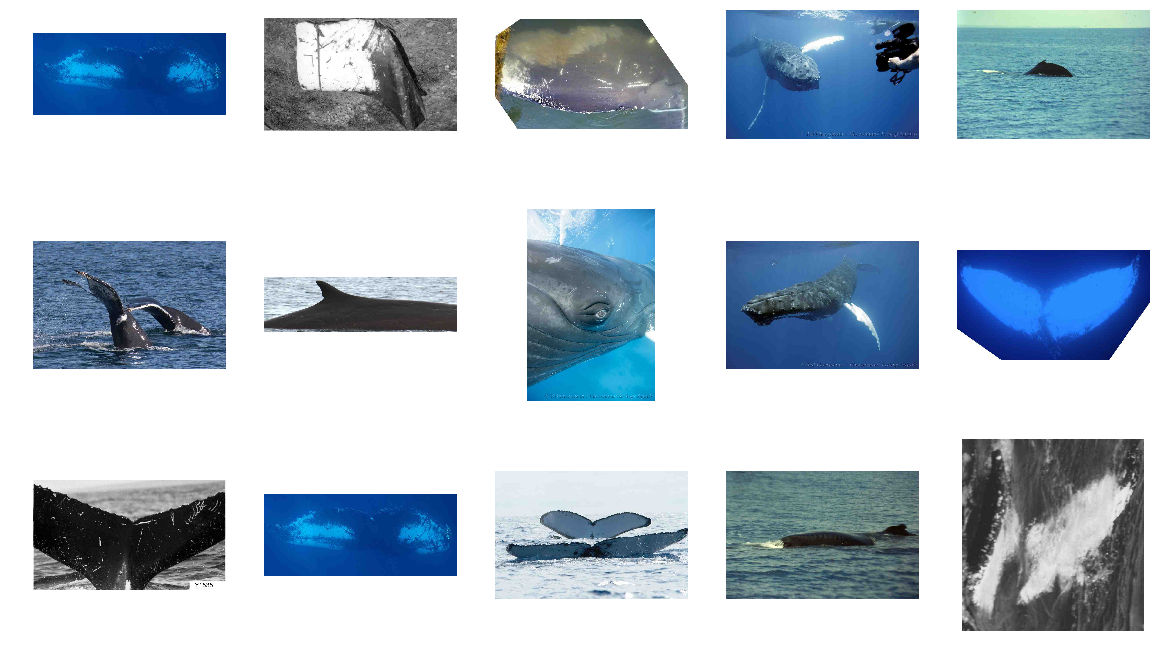

In [8]:
show_whale([pil_image.open(expand_path(img)) for img in exclude[14:29]], 5)
train_df = train_df[~train_df['Image'].isin(exclude)]
print('Excluded images: ')

Rotated whale tales: 


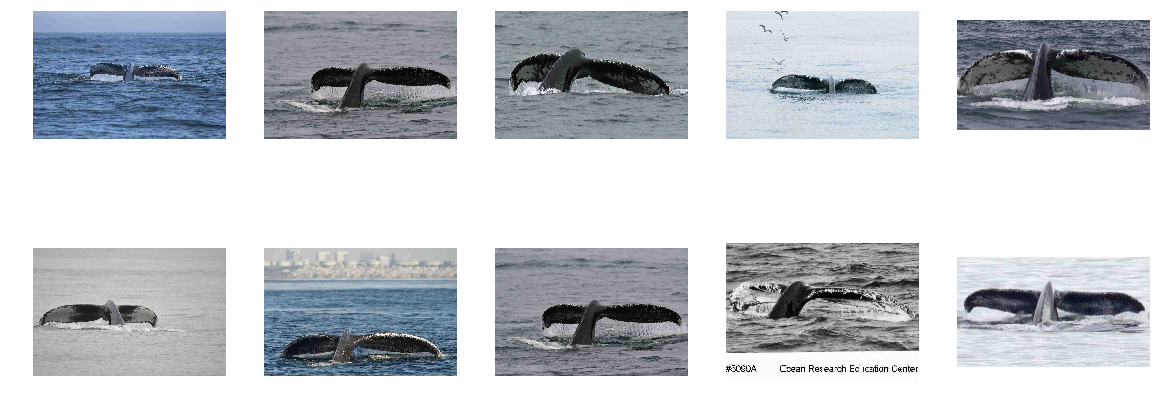

In [9]:
show_whale([pil_image.open(expand_path(img)) for img in rotate], 5)
print('Rotated whale tales: ')

In [10]:
train_df = train_df[train_df['Id'] != 'new_whale'].reset_index(drop=True)
train_df.shape

(9008, 2)

### Image loading

In [11]:
# The margin added around the bounding box to compensate for bounding box inaccuracy
IMAGE_SIZE = (224, 224)
crop_margin  = 0.05 
resize = transforms.Resize(IMAGE_SIZE)

def load_image(image_name):
    image = pil_image.open(expand_path(image_name)).convert('RGB')
    width, height = image.size

    # Crop bounding box with respect to crop margin
    x0, y0, x1, y1 = bboxes[image_name]
    dx = x1 - x0
    dy = y1 - y0
    x0 -= dx * crop_margin
    x1 += dx * crop_margin + 1
    y0 -= dy * crop_margin
    y1 += dy * crop_margin + 1
    if (x0 < 0):
        x0 = 0
    if (x1 > width):
        x1 = width
    if (y0 < 0):
        y0 = 0
    if (y1 > height):
        y1 = height
    try:
        # A few images have incorrect bounding boxes
        image = image.crop((x0, y0, x1, y1))
    except:
        pass
    # Rotate whale tails which are upside-down
    if image_name in rotate:
        image = image.rotate(180)
        
    return resize(image)

### Cache training images to speedup train dataloader

In [12]:
cache = {}

for image_name in tqdm_notebook(train_df['Image']):
    cache[image_name] = load_image(image_name)
    
def get_image(image_name):
    '''Returns cropped and resized image either from cache or from disk'''
    return cache.get(image_name) or load_image(image_name)

### Training / Validation datasets

In [13]:
class WhaleDataset(data.Dataset):
    '''
    PyTorch class for Whales' tails
    Link: https://www.kaggle.com/c/whale-categorization-playground/data

    Data issues mentioned:
    - some bboxes are incorrect
    '''

    def __init__(self, images_data, scope='train', augment=False):
        self.image_data = images_data
        self.scope = scope

        if augment:
            self.transform = transforms.Compose([
                transforms.ColorJitter(brightness=0, contrast=0.05, saturation=0.05),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)
            ])

        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)
            ])

        print('Images: {}. Augmentation: {}. Scope: {}.'.format(len(self.image_data), augment, scope))

    def __getitem__(self, idx):

        '''
        For train and validation triplets are required, for prediction - only images;
        '''
        image_mode = 'RGB'
        row = self.image_data.iloc[idx]
        anchor_name = row['Image']
        anchor = get_image(anchor_name)

        anchor = self.transform(anchor)
        if self.scope == 'train' or self.scope == 'val':
            anchor_id = row['Id']

            positive_candidates = list(self.image_data[self.image_data['Id'] == anchor_id]['Image'])
            positive_candidates = [x for x in positive_candidates if x != anchor_name]

            if len(positive_candidates) == 0:
                positive_name = anchor_name
            else:
                positive_name = np.random.choice(positive_candidates)

            negative_candidates = list(
                self.image_data[(self.image_data['Id'] != anchor_id)]['Image']
            )
            negative_name = np.random.choice(negative_candidates)

            positive = get_image(positive_name)
            negative = get_image(negative_name)

            positive = self.transform(positive)
            negative = self.transform(negative)

            return {'name': anchor_name,
                    'anchor': anchor,
                    'positive': positive,
                    'negative': negative
                    }
        else:
            return {'name': anchor_name, 'anchor': anchor}
    

    def __len__(self):
        return len(self.image_data)

#### Siamese NN validation is a little bit tricky. We will take only images from classes with more than 3 images per class.

In [14]:
# Group images by id
grouped = train_df.groupby('Id')

validation_indexes = []

for group in grouped.groups.items():
    indexes = group[1]
    # Take only one image from class which has at least 3 images
    if (len(indexes) > 2):
        validation_indexes.append(indexes[0])
        
validation_df = train_df.iloc[validation_indexes].reset_index(drop=True)
train_df = train_df[~train_df.index.isin(validation_indexes)].reset_index(drop=True)

validation_df.shape, train_df.shape

((992, 2), (8016, 2))

In [15]:
train_dataset = WhaleDataset(train_df, augment=True)
train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 4, drop_last=False)

Images: 8016. Augmentation: True. Scope: train.


In [16]:
validation_df = WhaleDataset(validation_df)
validation_dataloader = data.DataLoader(validation_df, batch_size=32, shuffle=False, num_workers = 4, drop_last=False)

Images: 992. Augmentation: False. Scope: train.


### Pretrained ResNet34  with 500 embeddings

In [17]:
EMBEDDINGS_SIZE = 500

class ResNet34(nn.Module):
    '''
    Last fully connected layer changed to ouput EMBEDDINGS_SIZE-dim vector.
    '''
    
    def __init__(self):
        super(ResNet34, self).__init__()
        self.model = models.resnet34(pretrained=True)
        self.model.fc = nn.Linear(in_features=512, out_features=EMBEDDINGS_SIZE, bias=True)

    def forward(self, image):
        features = self.model(image)
        return features


model = ResNet34().cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 74185983.06it/s]


### Define Triplet loss with margin 0.7

In [18]:
class TripletLossCosine(nn.Module):
    def __init__(self):
        super(TripletLossCosine, self).__init__()
        self.MARGIN = 0.7
            
    def forward(self, anchor, positive, negative):
        dist_to_positive = 1 - F.cosine_similarity(anchor, positive)
        dist_to_negative = 1 - F.cosine_similarity(anchor, negative)
        loss = F.relu(dist_to_positive - dist_to_negative + self.MARGIN)
        loss = loss.mean()
        return loss
    
loss_func = TripletLossCosine()

In [19]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.007, momentum=0.9)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.4)

### Training

In [20]:
def validate(model): 
    model.eval()
    batch_losses = []

    with torch.no_grad():
        for sample in validation_dataloader:
            for key in ['anchor','positive','negative']:
                sample[key] = sample[key].cuda()

        anchor_embed = model(sample['anchor'])
        positive_embed = model(sample['positive'])
        negative_embed = model(sample['negative'])
        loss = loss_func(anchor_embed, positive_embed, negative_embed) 

        batch_losses.append(loss.item())
    return batch_losses

In [21]:
train_losses = []
validation_losses = []

for epoch in range(1, 12):
    batch_losses = []

    for sample in tqdm_notebook(train_dataloader):
        model.train()
        optimizer.zero_grad()

        for key in ['anchor','positive','negative']:
            sample[key] = sample[key].cuda()

        anchor_embed = model(sample['anchor'])
        positive_embed = model(sample['positive'])
        negative_embed = model(sample['negative'])
        loss = loss_func(anchor_embed, positive_embed, negative_embed)  
        loss.backward()
        
        optimizer.step()
        if epoch == 10:
            optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0005, momentum=0.9)

#         lr_scheduler.step()
        batch_losses.append(loss.item())
        
    val_loss = validate(model)
    train_losses.append(np.mean(batch_losses))
    v = np.mean(val_loss)
    validation_losses.append(v)

    print('====Epoch {}. Train loss: {}. Val loss: {}'.format(epoch,  np.mean(batch_losses),  v))



====Epoch 1. Train loss: 0.18456015725475383. Val loss: 0.21631880879402163



====Epoch 2. Train loss: 0.10435668481476754. Val loss: 0.13097486019134522



====Epoch 3. Train loss: 0.08329504251153583. Val loss: 0.09828335444132487



====Epoch 4. Train loss: 0.07327218203104112. Val loss: 0.09503214597702027



====Epoch 5. Train loss: 0.0659687368503486. Val loss: 0.08753108257055282



====Epoch 6. Train loss: 0.05841301084010012. Val loss: 0.0799879722793897



====Epoch 7. Train loss: 0.052810896306755055. Val loss: 0.07770327981029237



====Epoch 8. Train loss: 0.04716952364016102. Val loss: 0.05443163797259331



====Epoch 9. Train loss: 0.04620109373087664. Val loss: 0.049149731397628786



====Epoch 10. Train loss: 0.04045731436268267. Val loss: 0.04733821958303452



====Epoch 11. Train loss: 0.039907652498835114. Val loss: 0.04960160166025162


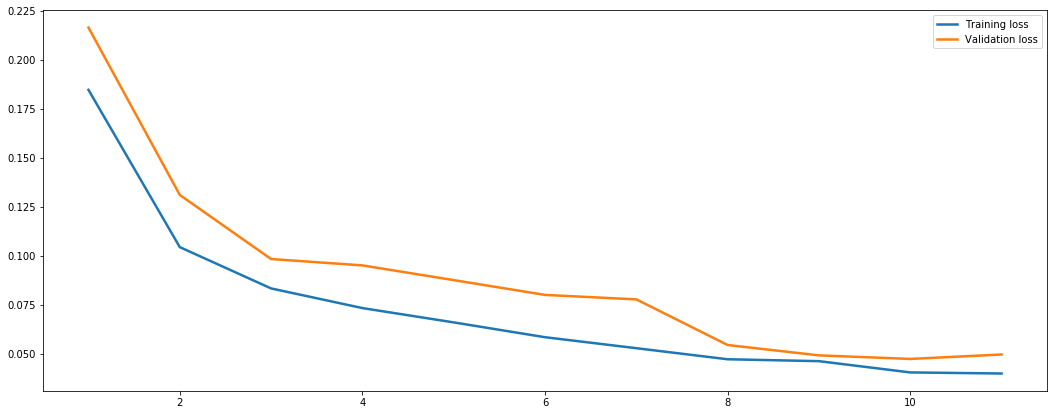

In [22]:
epochs = list(range(1, len(train_losses)+1))
fig, ax = plt.subplots(figsize=(18,7))

sns.lineplot(x=epochs, y=train_losses, palette="tab10", linewidth=2.5, ax=ax);
sns.lineplot(x=epochs, y=validation_losses, palette="tab10", linewidth=2.5, ax=ax);
ax.legend(['Training loss', 'Validation loss']);

### Calculate all embeddings

In [23]:
all_images = pd.DataFrame({'Image': pd.concat([train_df['Image'], test_df['Image']])}).reset_index(drop=True)

embed_dataset = WhaleDataset(all_images, scope='embed')
embed_dataloader = data.DataLoader(embed_dataset, batch_size=32, shuffle=False, num_workers = 4, drop_last=False)
embeddings_dict = {}

model.eval()
with torch.no_grad():
    for sample in tqdm_notebook(embed_dataloader):
        anchors = sample['anchor'].cuda()
        embeds = model(anchors)
        
        for image_name, embed in zip(sample['name'], embeds):
            embeddings_dict[image_name] = embed.cpu().numpy()

Images: 23626. Augmentation: False. Scope: embed.


In [24]:
assert len(embeddings_dict) == len(all_images)

In [25]:
train_embeds = np.zeros((len(train_df), EMBEDDINGS_SIZE))
test_embeds = np.zeros((len(test_df), EMBEDDINGS_SIZE))

for index, image_name in enumerate(train_df['Image']):
    train_embeds[index] = embeddings_dict[image_name]
    
for index, image_name in enumerate(test_df['Image']):
    test_embeds[index] = embeddings_dict[image_name]

In [26]:
similarities = cosine_similarity(test_embeds, train_embeds)

### Find top 5 classes and submit

In [27]:
def find_top_k(sims, k):
    top_sims = sims.argsort()[::-1]
    top_klasses = set(['new_whale'])
    for sim in top_sims:
        klass = train_df.iloc[sim]['Id']
        top_klasses.add(klass)
        if len(top_klasses) == k:
            break
    return ' '.join(top_klasses)


find_top_k(similarities[666], 5)


'w_7e4d894 w_046a210 w_231a0c8 new_whale w_449e238'

In [28]:
for index in tqdm_notebook(range(len(test_df))):
    test_df.iloc[index]['Id'] = find_top_k(similarities[index], 5)

In [29]:
test_df.to_csv('submission.csv', index=False)